# MCMC: A Beginnner's Guide

In this tutorial, I'll be going over the basics of MCMC and running an MCMC on some data. I'm not going to spend much time on the complicated bayesian math that goes into it, but for more detail you can check out http://dan.iel.fm/emcee/current/user/line/ 

For the purposes of this tutorial, we will simply use MCMC (through the Emcee python package), and discuss qualitatively what an MCMC does. 

## So what is MCMC?

MCMC stands for Markov-Chain Monte Carlo, and is a method for fitting models to data. This is a little different from a simple linear least squared or chi-squared fit we might perform to some data.

MCMC is a parameter space exploration tool - in short, a *sampler*. 

The fundamental process of running an MCMC is to compare generated **models** against **data**. Those models are generated by a set of **parameters**, and our goal is usually to find the set of parameters that produces the model that best fits our data. 

It's important to note that in order to be feasible, the MCMC process is inherently *Bayesian* as opposed to *frequentist*. What this means, practically, is that our MCMC requires us to impose what are known as **priors** on our parameters. These priors encode information we as modelers think we already know about the system we are modeling. For example, if I were constructing a model for the sun, I might impose a prior that the temperature at the core is within a certain range, because I know from observations that nuclear fusion is occcuring, and that this can only happen above certain temperatures. 

We then calculate the probability of our *model* given our *data*. The process is something like this: 

 - Establish a function that outputs a model given a set of input parameters
 - Establish an ensemble of walkers defined by a $\theta$ vector that contains a set of parameters as used by the model-generating function. For example, if we constructed a simple model that predicts the number of planets in an extrasolar system based on the host star's metallicity $Z$, mass $M$, and temperature $T$, a $\theta$ vector would look like: 
 \begin{equation}\theta_i = \begin{pmatrix} Z_i \\ M_i \\ T_i \end{pmatrix} \end{equation}
 - One can imagine a "grid" of possible values for $\theta$, within the prior ranges we've chosen to vary over. 
 - Every walker will now begin exploring the parameter space. To do this, each walker takes a "step" to a new value of $\theta$ and generates a model with that $\theta$. It then compares the model to the given data, usually via a simple $\chi^2$-type check
 \begin{equation} "Likeness" = -\frac{1}{2} \sum{\left(\frac{y_{data}-y_{model}}{y_{data,err}}\right)^{2}}\end{equation}
 - The MCMC then checks the ratio of the Likeness generated by the new model with the data vs. the previous model. Generally speaking, if the new location produces a better match, the walker moves there and repeats the process. If the new location is worse, it retreats to its previous position and tries a new direction. 
 - Eventually, the walkers all begin climbing towards the regions of highest "likeness" between the models generated in the data.
 
At the end of the process (known as a *production run*), we have what is known as a **posterior distribution** or **chain**. Every walker keeps a record of every $\theta$ vector it tried out, and the likelihood of the model given the data at that value of $\theta$. 

By some complicated mathematics I won't get into, this distribution, assuming the MCMC runs long enough to *converge* reasonably (that is, the distribution of walkers is not changing *en masse* as a function of step number), represents a sample of reasonable models to describe our data. 

It's reasonable to wonder what the "best fit" is. But rememeber that MCMC is not a "fitter," it is a "sampler." MCMC can't tell us that parameter set $\theta$ is the "best" - one our models will have the numerically highest value of "likeness" to the data, but if we re ran the MCMC, or ran it longer, etc., we will get different answers. What MCMC is better at telling us is something like "If you draw 100 random models out of the posterior distribution, the *spread* in those models is representitive of our ability to constrain the parameters in those models." 

The easiest way to see this is to jump in with an example!


## Fitting the Earth's Milankovich Cycles 

Located in this directory is a file containing the temperature change, age, deuterium content, etc., of the Earth's atmosphere over the last several million years, calculated from measurements of ice-core samples. For the purposes of this tutorial, we will be interested in only the age and temperature columns. 
The file is called 'ice_core_data.txt', and the ages and $\Delta T$ are in the third and fifth columns, respectively. Load the data and plot the Temperature deviation (from average) against age to see what we will be trying to fit in this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

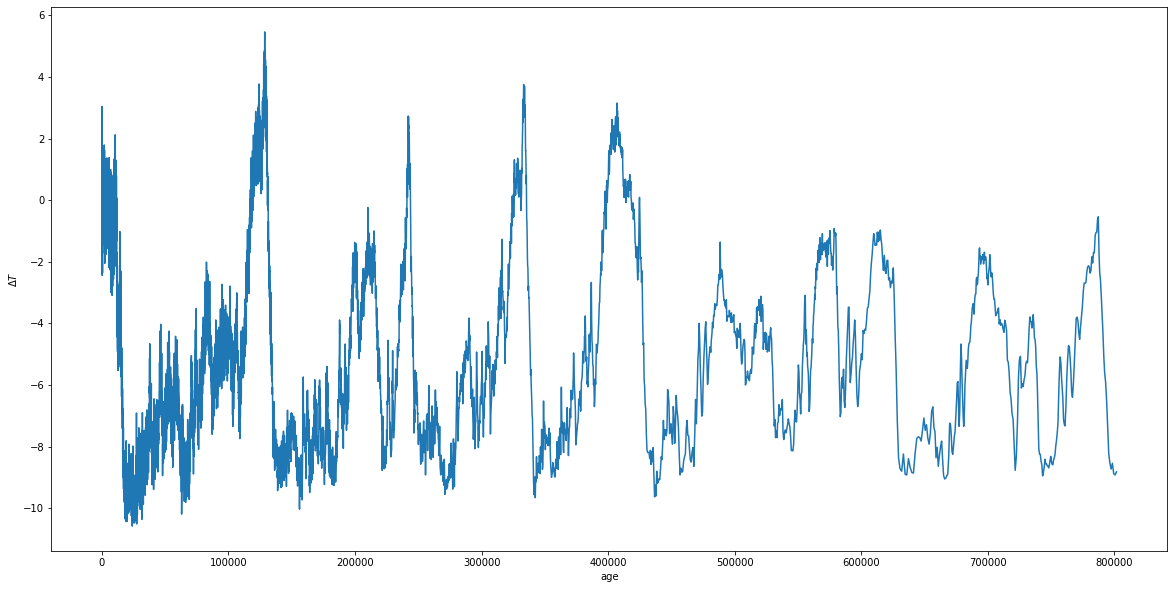

In [2]:
ice_data = np.loadtxt('ice_core_data.txt')
ice_data = np.transpose(ice_data)
age = ice_data[2]
T = ice_data[4]
plt.plot(age,T)
plt.xlabel('age')
plt.ylabel(r'$\Delta T$')
plt.show()


Great. Now, we can see that the temperature of Earth fluctuates a lot over its history, but that those fluctuations seem fairly periodic. It turns out, these fluctuations are due to combinations of small, but important periodic changes in the Earth's tilt (obliquity), rotational precession, orbital precession, eccentricity, and ecliptic inclination. Three of these effects were studied extensively by Milutin Milankovich and have come to be named after him. While not the only effects, they are three of the primary ones driving the fluctuations we see above. 

Those three effects are the obliquity, rotational precession, and eccentricity. For more on these effects, you can check out the wikipedia article: https://en.wikipedia.org/wiki/Milankovitch_cycles 

From the article, we can see that the periods of the Milankovich cycles are approximately 26,000 years, 41,000 years, and 100,000 years. While our model will actually end up fitting our periods for us, but having these numbers in mind will allow us to shorten our MCMC run by introducing good $priors$, which are a priori limitations on the allowed parameter values. For example, if you are simulating galaxy spectra, the age of the galaxy as a free parameter should not be allowed to be greater than the age of the universe. Why let the MCMC spend the time fitting models that are unphysical anyway? 

We can create a basic model for describing the above fluctuations as a sum of three sinusoids, which have different amplitudes and periods corresponding to roughly the Milankovich cycles. This won't work perfectly, but will be good enough for our purposes. Our model will be of the form 
$$
\Delta T = a_1 \sin\left(\frac{2\pi t}{p_1}\right) + a_2 \sin\left(\frac{2\pi t}{p_2}\right) + a_3 \sin\left(\frac{2\pi t}{p_3}\right) + T_0
$$
where $a_1, a_2, a_3, p_1, p_2, p_3,$ and $T_0$ are the parameters we will be fitting for.

## Setting up the MCMC

First, of course, you need an mcmc code- I will be using emcee, which can be installed using pip install emcee. 

We will be creating four functions for this MCMC run. The first is straightforward, and is known as the model. The model function should take as an argument a list representing our $\theta$ vector, and return the model evaluated at that $\theta$. For completion, your model function should also have your age array as an input, which here we can set to default to the age array defined above. Create your function below:

In [3]:
def model(theta,age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    return a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0

We now need a function referred to as lnlike(). This function takes as an argument theta as well as the $x$, $y$, and $y_{err}$ of your actual theta. It's job is to return a number corresponding to how good a fit your model is to your data for a given set of parameters, weighted by the error in your data points (i.e. it is more important the fit be close to data points with small error bars than points with large error bars). We will use the following formulation to determine this number- translate it to a function in python below:

$$
L_{lnlike} = -\frac{1}{2} \sum{\left(\frac{y-y_{model}}{y_{err}}\right)^{2}}
$$

In [4]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

The next function we need is one to check, before running the probability function (last one defined) on any set of parameters, that all variables are within their priors (in fact, this is where we set our priors). 

The output of this function is totally arbitrary (it is just encoding True False), but emcee asks that if all priors are satisfied, 0.0 is returned, otherwise return -np.inf. Its input is a $\theta$ vector.

Set up an lnprior function that specifies bounds on $a_1,a_2,a_3,p_1,p_2,p_3$ and $T_0$. Reasonable bounds on the amplitudes can be drawn from the plot above (the amplitudes individually can't be greater than the overall amplitude of the final fluctuations, and $T_0$ must be within the upper and lower bounds of the data we see). Priors on the periods are tricker, I suggest going for around ten thousand years around the known Milankovich cycle periods given above- we expect the values to be close to these. (We will talk a bit later about evaluating from "walker plots" whether our priors might not have been great). 

In [5]:
def lnprior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
        return 0.0
    return -np.inf

The last function we need to define is lnprob(). This function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), returning the lnlike for that model (by convention we say it's the lnprior output + lnlike output, since lnprior's output should be zero if the priors are good). lnprob needs to take as arguments theta, x, y, and $y_{err}$, since these get passed through to lnlike. 



In [6]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

We have one or two steps left before we can run. First, our Temperature measurements, unfortunately, have no errors provided. But we need errors for the MCMC to run, so let's set a yerr array arbitrarily to 5% of the average temperature in our temperature array. 

We will want to feed our data (x,y,yerr) in as a tuple, so set data equal to a tuple of our age, temperature and temperature error arrays. 

We also need to set a value for nwalkers, which determines how many walkers are initialized in our MCMC. Let's use 500.

We need a variable called initial, which is an initial set of guesses (this will be the first theta, where the MCMC starts). 

Finally we need p0, which is the methodology of stepping from one place to a grid to the next ( I will provide this). 

In [9]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 64
niter = 50
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

We are now ready to run the MCMC. I'll provide the code for this, since it just amounts to looking up emcee's documentation. 

In [10]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

The sampler here contains all the outputs of the MCMC, including the walker chains and the posteriors. We will talk a little bit later about evaluating whether an MCMC has "converged," but for now let's quickly extract a random sampling of our posteriors and plot them over our data.

In [11]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [19]:
def plotter(sampler,age=age,T=T):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
#     for theta in samples:
    for theta in samples[np.random.randint(len(samples), size=50)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

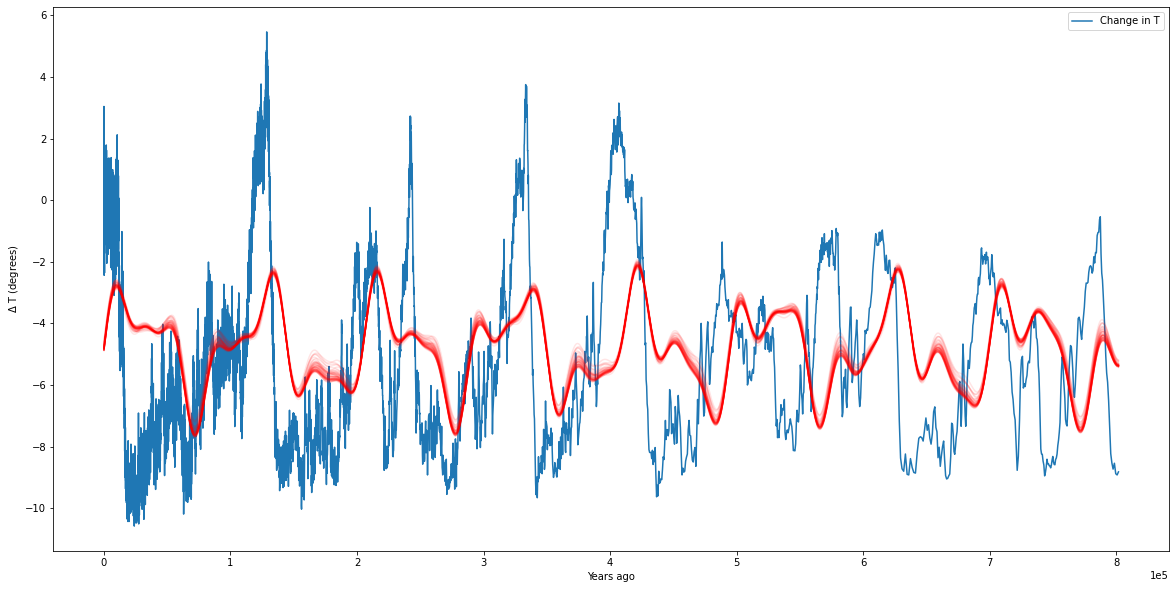

In [20]:
#sampler= main(p0)
plotter(sampler)

We can see from our plot that our simplistic model (of three sinusoids) is not perfect, but it does a pretty good job of matching our data. We can see that from the hundred samples we drew from the posteriors, they all seem to overlap over each other pretty well. We can see the exact values of our parameters as well: 


In [22]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 4.09130133e-01,  8.80497171e-01,  1.42054398e+00,  2.59912009e+04,
        4.09955467e+04,  9.99930919e+04, -4.90824132e+00])

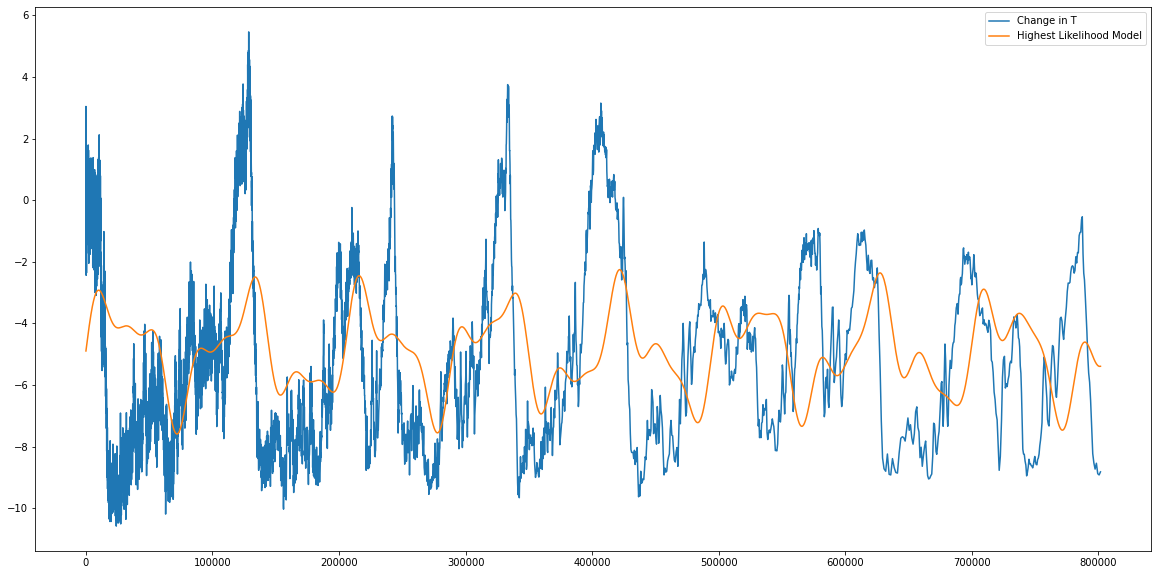

Theta max:  [ 4.09130133e-01  8.80497171e-01  1.42054398e+00  2.59912009e+04
  4.09955467e+04  9.99930919e+04 -4.90824132e+00]


In [25]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,best_fit_model,label='Highest Likelihood Model')
plt.legend()
plt.show()
print('Theta max: ',theta_max)

So we find that our amplitudes are 1.15, 2.15, and 2.04 (seems about right, they should be less than around 5), we get periods of 23,530 years, 39,836 years, and 96,277 years (pretty close to our predictions of 26,000, 41,000, and 100,000 years), and a $T_0$ of -5.24 degrees, which we almost could've read straight off the graph in the first place. My simple check above just takes the averages of the posteriors, which is hardly bayesian, but we can also look at, for example, the standard deviation (spread) in posteriors. 

### Posterior Spread
We can use the corner.py module to visualize 1D and 2D spreads between the parameters we are testing, and get some uncertainties on our paraemter estimations.

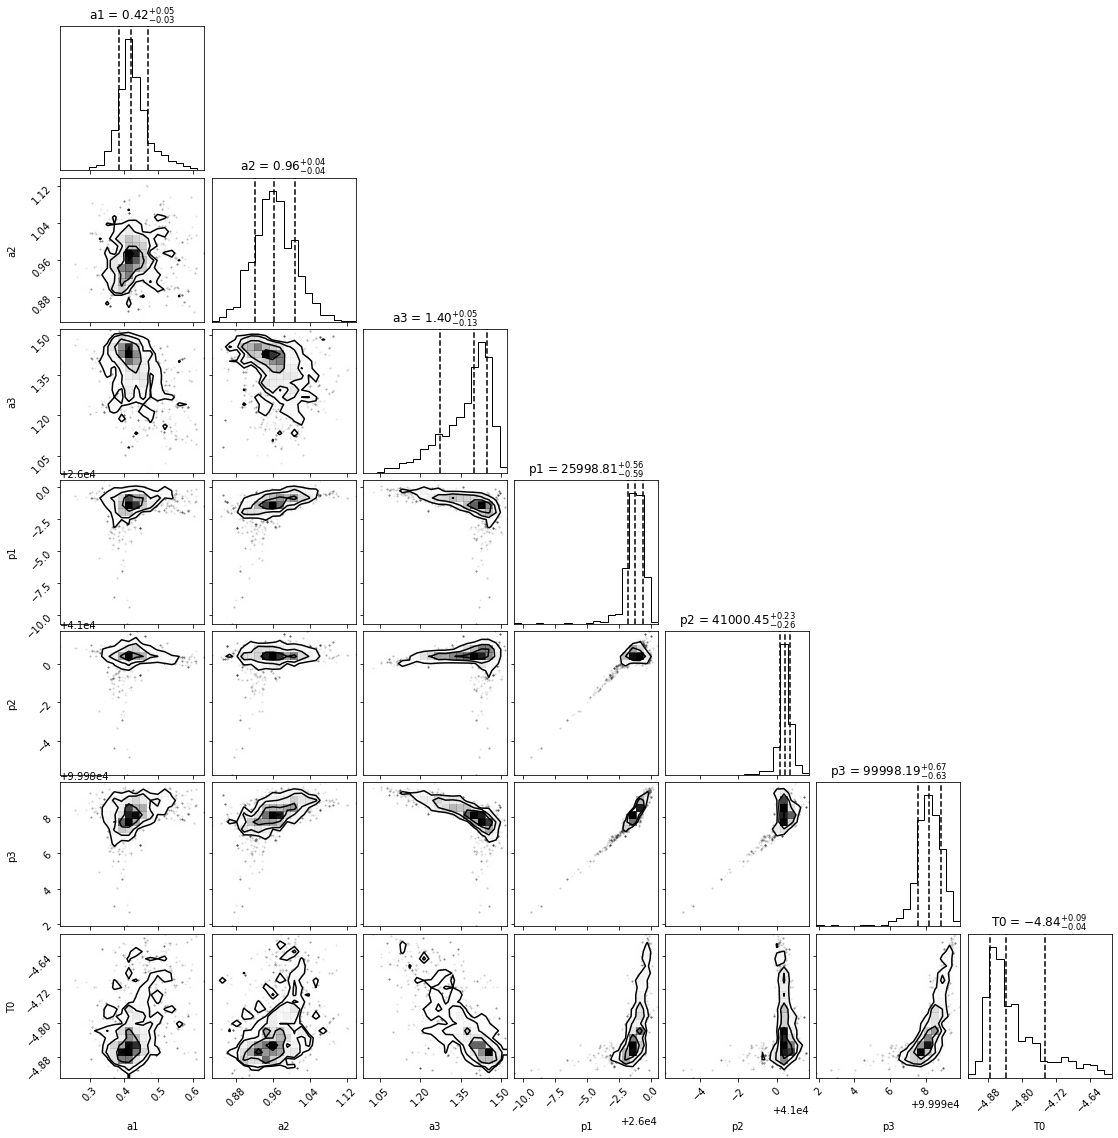

In [26]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In all honesty, these look pretty awful, with bimodalities and clumps all over the place. All of this is indicative of the fact that we chose a pretty crappy model in the first place. Take a look at a1: the two peaks at different amplitudes show that we haven't converged on a single answer, and if you look at the plot where I simply draw from the posteriors, at the very first peak you can see the two modes of amplitude. It's possible that more walkers and more iterations could help us solve this -- let's give it a try. 

In [64]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 240
niter = 1024
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in xrange(nwalkers)]
new_sampler, newpos, newprob, newstate = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


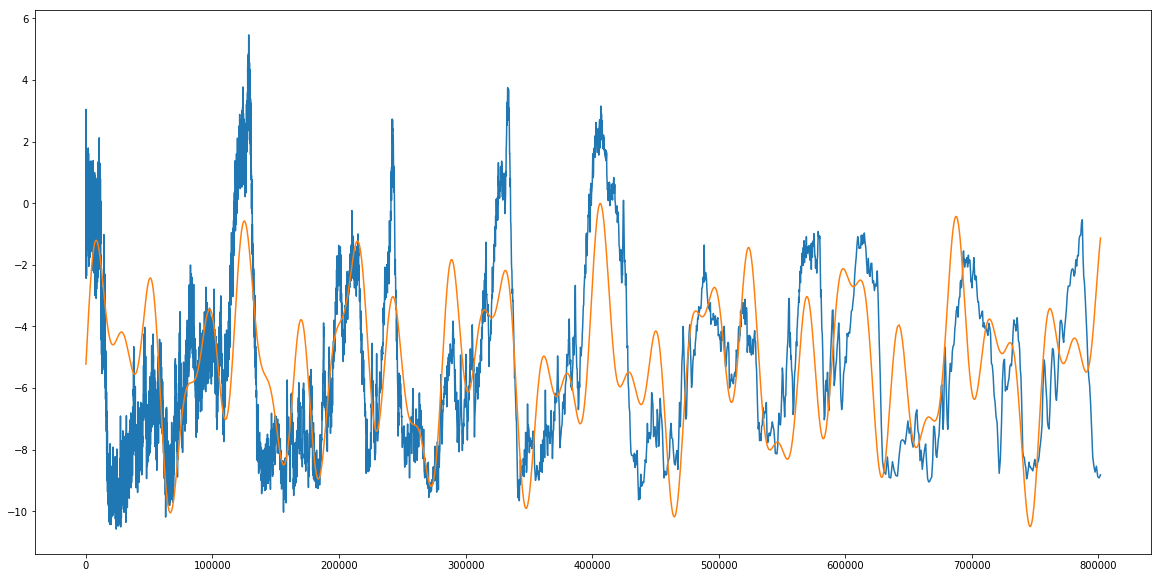

Theta max:  [  1.32723884e+00   2.07934292e+00   1.89735570e+00   2.35215810e+04
   3.97328136e+04   9.61323211e+04  -5.25707013e+00]


In [66]:
new_samples =  new_sampler.flatchain

new_theta_max  = new_samples[np.argmax(new_sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.show()
print 'Theta max: ',new_theta_max

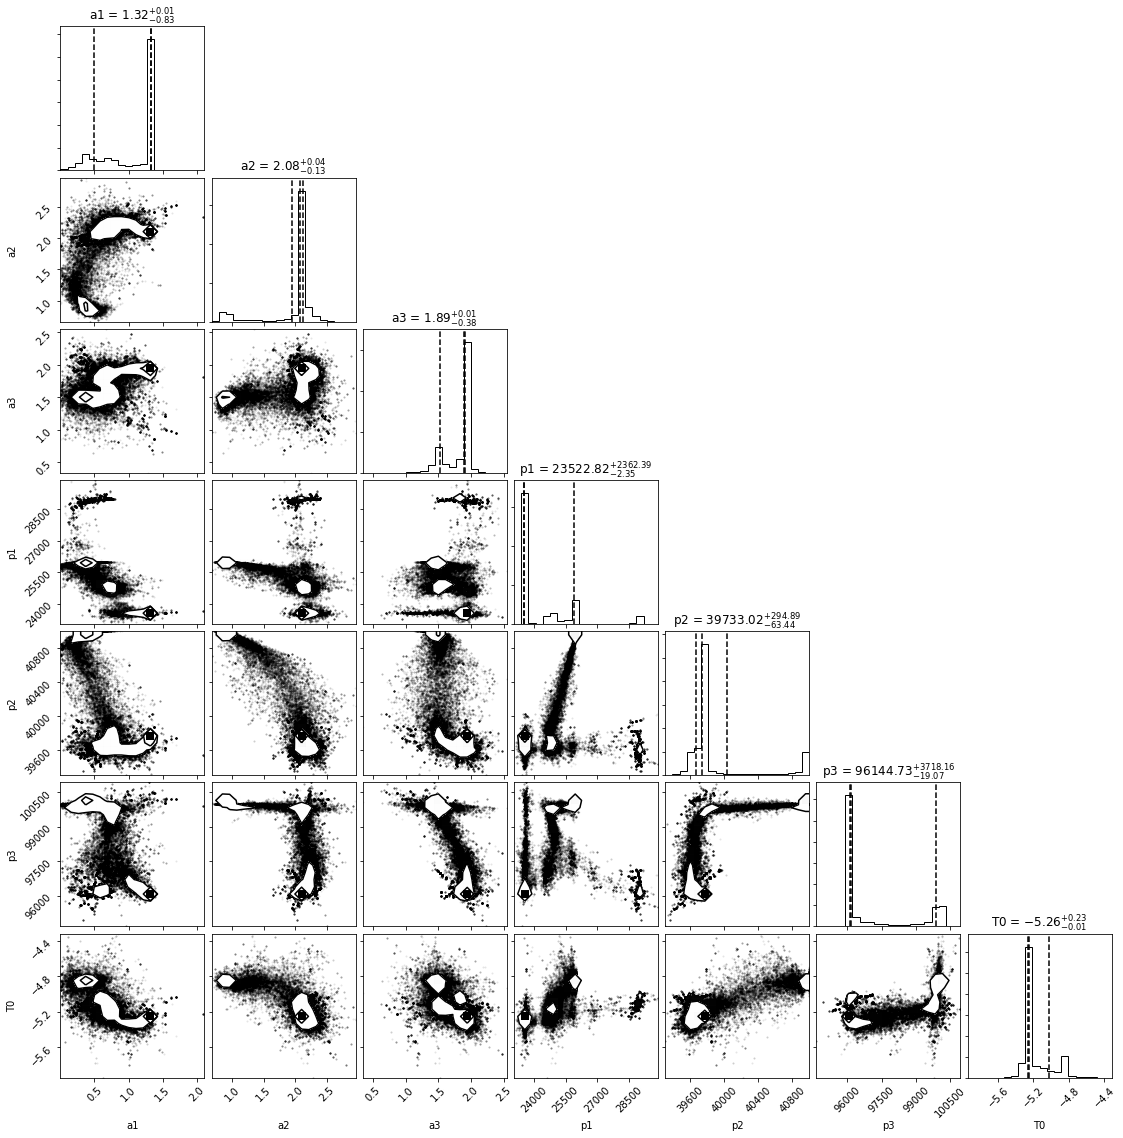

In [67]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

A lot of things still look crappy, but we can see that the secondary modes seems to be supressed -- most of the models now favor a single value. So what about plotting a one sigma spread in posteriors over the theta max we plotted? Easy! All we need to do is draw a random sample from the posteriors and find the spread at each "x-value" where we evaluated our model.

In [71]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,new_samples)

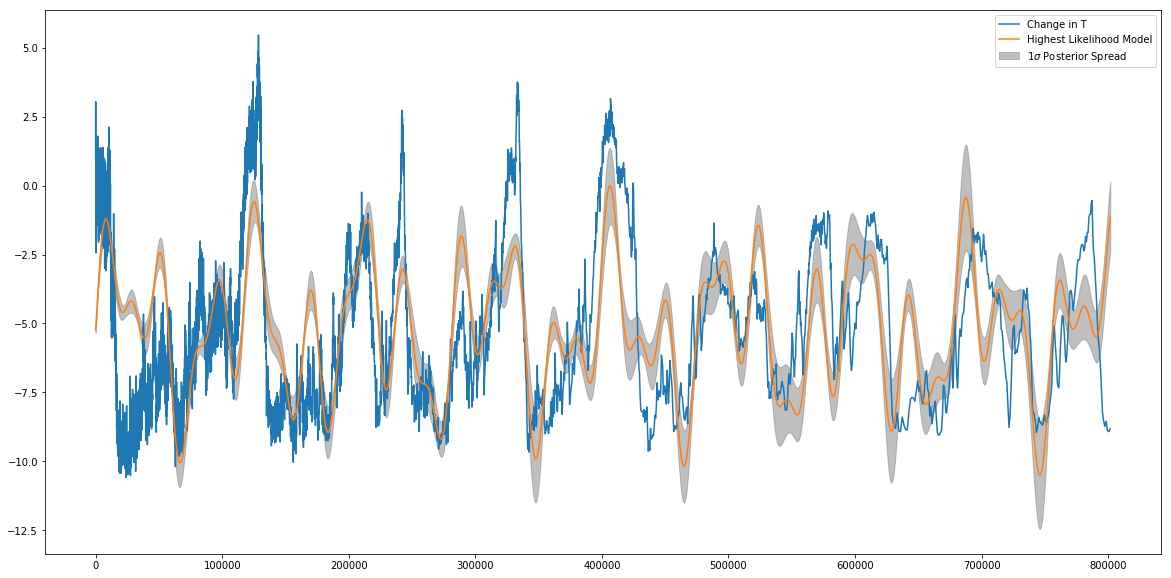

In [73]:
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(age,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.legend()

Note that the "Most likely" model doesn't always have to (and sometimes doesn't) sit at the center of this spread- the spread is around the median model, but the one that absolutely maximizes the likelihood might sit at the edge or even outside this region. 

This has been an interesting test example. It's worth noting that though our model was kind of crappy, using the data we were able to fit for the periods of the Milankovich cycles pretty accurately. 

Congrats! You made it to the end of the tutorial. I hope you enjoyed it, practiced a little python, and learned something about galaxy properties. As always, feel free to contact me (post an issue on the github http://github.com/prappleizer/prappleizer.github.io ) if anything was messed up, confusing, or poorly explained.